<a href="https://colab.research.google.com/github/AbhinavPandey1911/OrbitVids/blob/main/checkks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook as tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import f1_score
#from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pickle
import random
import warnings
warnings.filterwarnings('ignore')


In [4]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 30, in <module>
    if ('P' not in gpu_name):
TypeError: a bytes-like object is required, not 'str'


In [5]:
import cudf

filename = '/content/drive/MyDrive/Colab Notebooks/unbalaced_20_80_dataset.csv'
data = cudf.read_csv(filename, index_col=False,nrows=4000000)
print('Dataframe shape on GPU:', data.shape)
print(data.tail(100))

Dataframe shape on GPU: (4000000, 85)
         Unnamed: 0                                   Flow ID          Src IP  \
3999900     4840786   172.31.67.48-209.85.203.149-49968-443-6    172.31.67.48   
3999901     5039100        172.31.67.6-52.84.4.54-53220-443-6     172.31.67.6   
3999902     4101867  172.31.66.71-209.10.106.141-3389-53042-6  209.10.106.141   
3999903     6677074       172.31.66.24-72.21.91.29-49315-80-6     72.21.91.29   
3999904     6782535       172.31.0.2-172.31.66.92-53-52556-17    172.31.66.92   
...             ...                                       ...             ...   
3999995     5169319     172.31.67.96-50.97.40.233-50193-443-6    50.97.40.233   
3999996     1611969   169.254.169.254-172.31.67.15-80-51546-6    172.31.67.15   
3999997     2718961      172.31.0.2-172.31.65.107-53-62555-17   172.31.65.107   
3999998     3156443  172.31.65.72-204.62.193.124-3389-51102-6  204.62.193.124   
3999999     2157748    172.31.64.19-13.89.190.129-49692-443-6    172.31

In [6]:
# 1. Identify columns with null values (NaN)
import cupy as cp
nan_cols = []
for col in data.columns:
    if data[col].null_count > 0:
        nan_cols.append(col)

print('Columns with null values:\n', nan_cols, '\n')


# Define infinity values for cuDF
infinity_values = [cp.inf, -cp.inf]

# Identify columns with infinity values (inf or -inf)
inf_columns = []
for col in data.columns:
    if (data[col].isin(infinity_values)).any():
        inf_columns.append(col)

print('\n Columns with inf or -inf values:\n', inf_columns, '\n')

Columns with null values:
 ['Flow Byts/s'] 


 Columns with inf or -inf values:
 ['Flow Byts/s', 'Flow Pkts/s'] 



In [7]:
data['Flow Pkts/s'] = data['Flow Pkts/s'].replace(cp.inf, cp.nan)
data['Flow Byts/s'] = data['Flow Byts/s'].replace(cp.inf, cp.nan)

# Now you can safely fill missing values (NaN) with the mean
print('Filling \'Flow Pkts/s\' NA values with mean:', data['Flow Pkts/s'].mean())
data['Flow Pkts/s'].fillna(data['Flow Pkts/s'].mean(), inplace=True)

print('Filling \'Flow Byts/s\' NA values with mean:', data['Flow Byts/s'].mean())
data['Flow Byts/s'].fillna(data['Flow Byts/s'].mean(), inplace=True)


Filling 'Flow Pkts/s' NA values with mean: 29711.69816418235
Filling 'Flow Byts/s' NA values with mean: 284365.1261561364


In [8]:
drop_lst = []
catfeat = []
for col in tqdm(data.columns):
 if len(data[col].unique())==1:
  drop_lst.append(col)
 elif len(data[col].unique())<=2:
  catfeat.append(col)
catfeat.append('y')
print('Columns with single value:\n',np.array(drop_lst),'\n')
print('Categorical columns:\n',np.array(catfeat),'\n')


  0%|          | 0/85 [00:00<?, ?it/s]

Columns with single value:
 ['Fwd URG Flags' 'Bwd URG Flags' 'Fwd Byts/b Avg' 'Fwd Pkts/b Avg'
 'Fwd Blk Rate Avg' 'Bwd Byts/b Avg' 'Bwd Pkts/b Avg' 'Bwd Blk Rate Avg'] 

Categorical columns:
 ['Fwd PSH Flags' 'Bwd PSH Flags' 'FIN Flag Cnt' 'SYN Flag Cnt'
 'RST Flag Cnt' 'PSH Flag Cnt' 'ACK Flag Cnt' 'URG Flag Cnt'
 'CWE Flag Count' 'ECE Flag Cnt' 'Label' 'y'] 



In [9]:
print('Dataframe shape before trimming:',data.shape)
# final_data = data
drop_lst.extend(['Label','Flow ID','Timestamp','Unnamed: 0'])
print('\nDropping following columns:\n',np.array(drop_lst))
final_data = data.drop(drop_lst,axis=1)
print('\nDataframe shape after trimming:',final_data.shape)


Dataframe shape before trimming: (4000000, 85)

Dropping following columns:
 ['Fwd URG Flags' 'Bwd URG Flags' 'Fwd Byts/b Avg' 'Fwd Pkts/b Avg'
 'Fwd Blk Rate Avg' 'Bwd Byts/b Avg' 'Bwd Pkts/b Avg' 'Bwd Blk Rate Avg'
 'Label' 'Flow ID' 'Timestamp' 'Unnamed: 0']

Dataframe shape after trimming: (4000000, 73)


In [10]:
final_data['y'] = cp.asarray(data['Label'].to_numpy() == 'ddos', dtype=cp.int32)
final_data['Src IP'] = cp.array([int(''.join(x.split('.'))) for x in data['Src IP'].to_numpy()])
final_data['Dst IP'] = cp.array([int(''.join(x.split('.'))) for x in data['Dst IP'].to_numpy()])


In [11]:
print('\nFinal data shape:', final_data.shape)
final_data.head()



Final data shape: (4000000, 74)


,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,y
0,1821919320,37882,172316925,80,6,8660,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,172316928,80,1821991,63287,6,5829,4,3,935.0,298.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,5214136135,63095,172316928,80,6,3396,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,18216200189,52341,172316928,80,6,2390,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,172316928,80,1821855126,57459,6,17362,4,3,935.0,314.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [12]:
lst = [i for i in final_data.columns if i not in catfeat]
print(len(lst))
print(np.array(lst))
print(len(final_data.columns))
print(final_data.columns)

63
['Src IP' 'Src Port' 'Dst IP' 'Dst Port' 'Protocol' 'Flow Duration'
 'Tot Fwd Pkts' 'Tot Bwd Pkts' 'TotLen Fwd Pkts' 'TotLen Bwd Pkts'
 'Fwd Pkt Len Max' 'Fwd Pkt Len Min' 'Fwd Pkt Len Mean' 'Fwd Pkt Len Std'
 'Bwd Pkt Len Max' 'Bwd Pkt Len Min' 'Bwd Pkt Len Mean' 'Bwd Pkt Len Std'
 'Flow Byts/s' 'Flow Pkts/s' 'Flow IAT Mean' 'Flow IAT Std' 'Flow IAT Max'
 'Flow IAT Min' 'Fwd IAT Tot' 'Fwd IAT Mean' 'Fwd IAT Std' 'Fwd IAT Max'
 'Fwd IAT Min' 'Bwd IAT Tot' 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Max'
 'Bwd IAT Min' 'Fwd Header Len' 'Bwd Header Len' 'Fwd Pkts/s' 'Bwd Pkts/s'
 'Pkt Len Min' 'Pkt Len Max' 'Pkt Len Mean' 'Pkt Len Std' 'Pkt Len Var'
 'Down/Up Ratio' 'Pkt Size Avg' 'Fwd Seg Size Avg' 'Bwd Seg Size Avg'
 'Subflow Fwd Pkts' 'Subflow Fwd Byts' 'Subflow Bwd Pkts'
 'Subflow Bwd Byts' 'Init Fwd Win Byts' 'Init Bwd Win Byts'
 'Fwd Act Data Pkts' 'Fwd Seg Size Min' 'Active Mean' 'Active Std'
 'Active Max' 'Active Min' 'Idle Mean' 'Idle Std' 'Idle Max' 'Idle Min']
74
Index(['Src IP',

In [13]:
del data

In [14]:
import gc
gc.collect()

0

No. of Attacks classified as DDoS= 1294529
No. of Attacks NOT classified as DDoS= 2705471


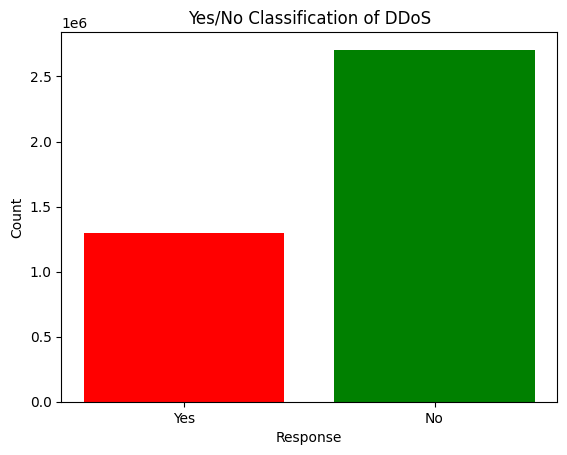

In [15]:
labels=final_data['y']
labels.head()
labels_array=labels.to_numpy()
yes_count = np.sum(labels_array == 1)
no_count = np.sum(labels_array == 0)
print("No. of Attacks classified as DDoS=",yes_count)
print("No. of Attacks NOT classified as DDoS=",no_count)

# Data
alllabels = ['Yes', 'No']
counts = [yes_count, no_count]

# Plot
plt.bar(alllabels, counts, color=['red', 'green'])
plt.title('Yes/No Classification of DDoS')
plt.xlabel('Response')
plt.ylabel('Count')
plt.show()
del(labels_array)
del(yes_count)
del(no_count)
del(alllabels)
del(counts)

In [16]:
import gc
gc.collect()

3984

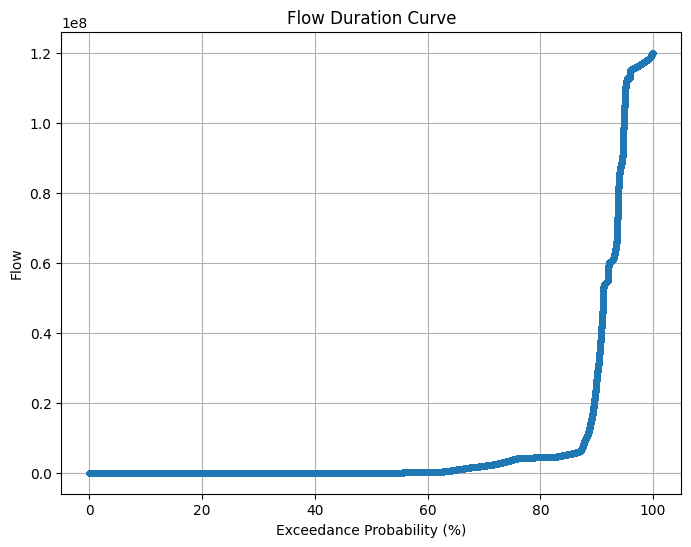

In [17]:
final_data['Flow Duration'].head()
flow_duration_data = np.sort(final_data['Flow Duration'])
exceedance_probability = np.linspace(0, 100, len(flow_duration_data))

# Plot
plt.figure(figsize=(8, 6))
plt.plot(exceedance_probability, flow_duration_data, marker='.', linestyle='-')
plt.title('Flow Duration Curve')
plt.xlabel('Exceedance Probability (%)')
plt.ylabel('Flow')
plt.grid(True)
plt.show()
del(flow_duration_data)
del(exceedance_probability)

In [18]:
import gc
gc.collect()

3580

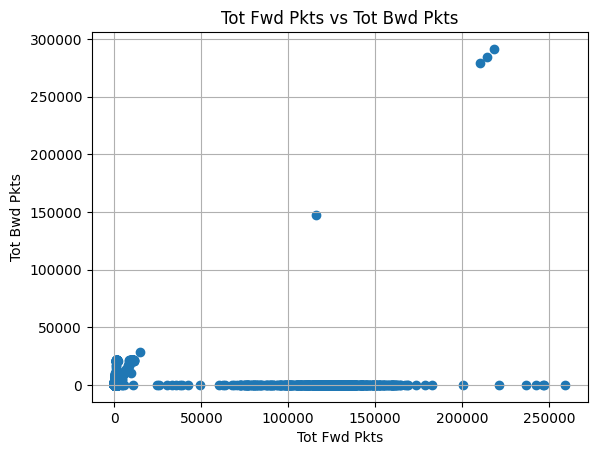

In [19]:
totfwd=final_data['Tot Fwd Pkts'].to_numpy()
totbwd=final_data['Tot Bwd Pkts'].to_numpy()
plt.scatter(totfwd, totbwd)
plt.title('Tot Fwd Pkts vs Tot Bwd Pkts')
plt.xlabel('Tot Fwd Pkts')
plt.ylabel('Tot Bwd Pkts')
plt.grid(True)
plt.show()
del(totfwd)
del(totbwd)

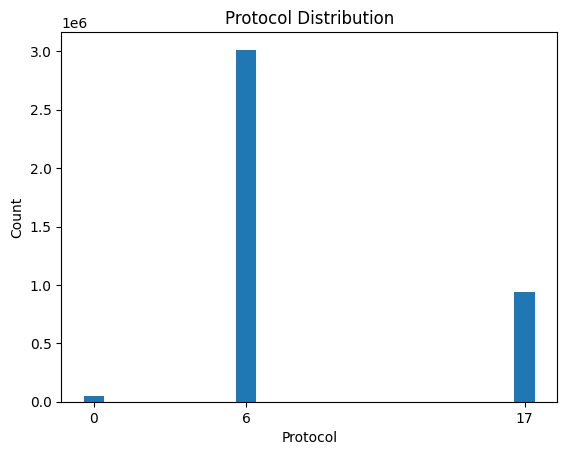

In [20]:
pc=final_data['Protocol'].to_numpy()
unique_protocols, protocol_counts = np.unique(pc, return_counts=True)

# Plot
plt.bar([0,6,17], protocol_counts, width=0.8)  # Set width as desired
plt.title('Protocol Distribution')
plt.xlabel('Protocol')
plt.ylabel('Count')

# Set x-axis tick positions and labels
plt.xticks([0,6,17], unique_protocols)

plt.show()



In [21]:
import gc
gc.collect()
print(type(final_data))
del(unique_protocols)
del(protocol_counts)

<class 'cudf.core.dataframe.DataFrame'>


In [22]:
import gc
gc.collect()

0

In [23]:
from cuml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_data.drop('y', axis=1), final_data['y'], test_size=0.2, random_state=42, stratify=final_data['y'])


In [24]:
for i in tqdm(lst):
 minimum = X_train[i].min()
 maximum = X_train[i].max()
 X_train[i] = (X_train[i] - minimum)/(maximum - minimum)
 X_test[i] = (X_test[i] - minimum)/(maximum - minimum)

  0%|          | 0/63 [00:00<?, ?it/s]

In [25]:
X_train.head()


,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
1796069,0.008608,0.885542,0.041989,0.006760,0.352941,4.166667e-08,0.000004,0.000003,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3231758,0.000772,0.776013,0.020455,0.006760,0.352941,4.826234e-01,0.000081,0.000058,0.000242,1.054601e-05,...,0.000042,0.416667,0.006995,0.022806,0.034559,0.000104,0.083761,0.001406,0.084797,0.082499
1602638,0.000772,0.852125,0.000007,0.000809,1.000000,3.525000e-06,0.000004,0.000003,0.000005,9.048352e-08,...,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2056701,0.008653,0.814755,0.000675,0.051714,0.352941,2.770821e-02,0.000031,0.000027,0.000138,2.466456e-06,...,0.000019,0.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1397320,0.000772,0.763256,0.059196,0.006760,0.352941,9.722879e-01,0.000054,0.000055,0.000098,1.669733e-05,...,0.000027,0.416667,0.001502,0.001974,0.002445,0.000559,0.484491,0.002056,0.485398,0.483585


In [26]:
del final_data


In [27]:
import gc
gc.collect()

2258

In [28]:
import gc
gc.collect()

235

In [29]:
def cross_validation(mod):
 print('calling cross_val_score with cv=5 for test data:')
 scoring = ['f1', 'f1_macro']
 scores = cross_validate(mod, X_test_cpu, y_test_cpu, cv=5, scoring=scoring)
 return scores

In [30]:
X_train_cpu = X_train.to_numpy()
y_train_cpu = y_train.to_numpy()

# Model training on CPU with scikit-learn
params = {'C': [0.05, 0.5, 50, 500]}
x_clf_1 = LogisticRegression(n_jobs=-1)
random_clf_1 = RandomizedSearchCV(x_clf_1, param_distributions=params, scoring='f1', verbose=10, cv=2)
random_clf_1.fit(X_train_cpu, y_train_cpu)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2; 1/4] START C=0.05......................................................
[CV 1/2; 1/4] END .......................C=0.05;, score=0.961 total time=  39.5s
[CV 2/2; 1/4] START C=0.05......................................................
[CV 2/2; 1/4] END .......................C=0.05;, score=0.961 total time=  42.1s
[CV 1/2; 2/4] START C=0.5.......................................................
[CV 1/2; 2/4] END ........................C=0.5;, score=0.975 total time=  37.3s
[CV 2/2; 2/4] START C=0.5.......................................................
[CV 2/2; 2/4] END ........................C=0.5;, score=0.975 total time=  36.9s
[CV 1/2; 3/4] START C=50........................................................
[CV 1/2; 3/4] END .........................C=50;, score=0.978 total time=  36.9s
[CV 2/2; 3/4] START C=50........................................................
[CV 2/2; 3/4] END .........................C=50;, 

RandomizedSearchCV(cv=2, estimator=LogisticRegression(n_jobs=-1),
                   param_distributions={'C': [0.05, 0.5, 50, 500]},
                   scoring='f1', verbose=10)

In [31]:
print(random_clf_1.best_params_)
print(random_clf_1.best_score_)


{'C': 50}
0.9779744601072313


In [32]:
model1 = LogisticRegression(C=random_clf_1.best_params_['C'], penalty='l2', random_state=42, n_jobs=-1, verbose=1)
model1.fit(X_train_cpu,y_train_cpu)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LogisticRegression(C=50, n_jobs=-1, random_state=42, verbose=1)

In [35]:
X_test_cpu=X_test.to_numpy()
y_test_cpu=y_test.to_numpy()

subset_size = 10 # Number of data points to save
random_indices = np.random.choice(len(X_test_cpu), size=subset_size, replace=False)

# Select subset data
X_subset = X_test_cpu[random_indices]
y_subset = y_test_cpu[random_indices]


# Convert to DataFrame
subset_df = pd.DataFrame(X_subset)
subset_df['target'] = y_subset

# Save to CSV
subset_df.to_csv('subset_data.csv', index=False)



ypred = model1.predict(X_train_cpu)
# print(ypred)
f1score = f1_score(y_train_cpu, np.round(ypred))
print('f1_score for train:',f1score)
ypred = model1.predict(X_test_cpu)
f1score = f1_score(y_test_cpu, np.round(ypred))
print('f1_score for test:',f1score)
# Dumping model in pickle file
with open('LR.pkl', 'wb') as fp:
 pickle.dump(model1, fp, protocol=pickle.HIGHEST_PROTOCOL)

f1_score for train: 0.9779127537952416
f1_score for test: 0.9783508100943878


In [36]:

# Load the model from file
with open('LR.pkl', 'rb') as infile:
    model = pickle.load(infile)

# Close the file after loading
infile.close()
scores = cross_validation(model)
print(scores)

calling cross_val_score with cv=5 for test data:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


{'fit_time': array([19.24821639, 15.63191509, 15.65384102, 14.84869933, 14.5403409 ]), 'score_time': array([0.19159389, 0.32448435, 0.29419041, 0.18993068, 0.2012794 ]), 'test_f1': array([0.97785241, 0.97887662, 0.97682946, 0.97731504, 0.97756703]), 'test_f1_macro': array([0.98357841, 0.98434218, 0.982822  , 0.98317997, 0.98336935])}


In [37]:

print('mean test f1_score: ',scores['test_f1'].mean())
print('mean test macro_f1: ',scores['test_f1_macro'].mean())

mean test f1_score:  0.9776881103059154
mean test macro_f1:  0.9834583837558041


In [38]:

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

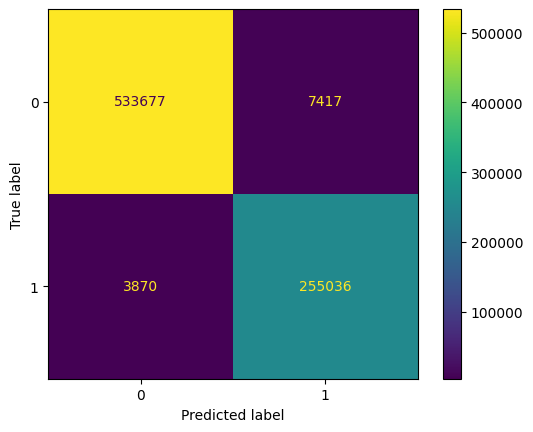

5

In [39]:

cm = confusion_matrix(y_test_cpu, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp.plot(values_format='')  # Remove values from matrix cells
plt.show()
del model
del model1
gc.collect()

In [40]:

var = np.logspace(0,-9, num=10)
print(var)
np.random.seed(999)
params = {'var_smoothing': var}
x_clf_2 = GaussianNB()
random_clf_2 = RandomizedSearchCV(x_clf_2, param_distributions=params, scoring='f1', verbose=10, cv=2)
random_clf_2.fit(X_train_cpu,y_train_cpu)

[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09]
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START var_smoothing=1.0..........................................
[CV 1/2; 1/10] END ...........var_smoothing=1.0;, score=0.772 total time=  12.9s
[CV 2/2; 1/10] START var_smoothing=1.0..........................................
[CV 2/2; 1/10] END ...........var_smoothing=1.0;, score=0.772 total time=   9.4s
[CV 1/2; 2/10] START var_smoothing=0.09999999999999999..........................
[CV 1/2; 2/10] END var_smoothing=0.09999999999999999;, score=0.851 total time=   7.4s
[CV 2/2; 2/10] START var_smoothing=0.09999999999999999..........................
[CV 2/2; 2/10] END var_smoothing=0.09999999999999999;, score=0.851 total time=   8.6s
[CV 1/2; 3/10] START var_smoothing=0.01.........................................
[CV 1/2; 3/10] END ..........var_smoothing=0.01;, score=0.851 total time=   6.7s
[CV 2/2; 3/10] START var_smoothing=0.01........

RandomizedSearchCV(cv=2, estimator=GaussianNB(),
                   param_distributions={'var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
                   scoring='f1', verbose=10)

In [41]:
model2 = GaussianNB(var_smoothing=random_clf_2.best_params_['var_smoothing'])
model2.fit(X_train_cpu,y_train_cpu)


GaussianNB(var_smoothing=0.09999999999999999)

In [42]:
ypred = model2.predict(X_train_cpu)
f1score = f1_score(y_train_cpu, ypred)
print('f1_score for train:',f1score)
ypred = model2.predict(X_test_cpu)
f1score = f1_score(y_test_cpu, ypred)
print('f1_score for test:',f1score)
# Dumping model in pickle file
with open('NB.pkl', 'wb') as fp:
 pickle.dump(model2, fp, protocol=pickle.HIGHEST_PROTOCOL)

f1_score for train: 0.8510182028067979
f1_score for test: 0.8512216104307213


In [43]:

infile = open('NB.pkl','rb')
model = pickle.load(infile)
infile.close()
scores = cross_validation(model)
print(scores)


calling cross_val_score with cv=5 for test data:
{'fit_time': array([1.04310346, 1.02965713, 1.22549343, 1.20623064, 1.07221365]), 'score_time': array([0.31325483, 0.32740951, 0.36364245, 0.35674238, 0.33593345]), 'test_f1': array([0.85146294, 0.84917177, 0.85074284, 0.85202491, 0.85278318]), 'test_f1_macro': array([0.88506048, 0.88320677, 0.88458754, 0.8855042 , 0.88611018])}


In [44]:

print('mean test f1_score: ',scores['test_f1'].mean())
print('mean test macro_f1: ',scores['test_f1_macro'].mean())

mean test f1_score:  0.8512371257803203
mean test macro_f1:  0.884893834944035


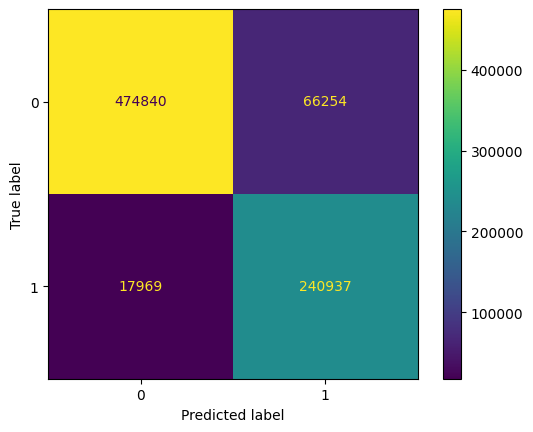

5055

In [45]:

cm = confusion_matrix(y_test_cpu, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp.plot(values_format='')  # Remove values from matrix cells
plt.show()
del model
del model2
gc.collect()

In [46]:
gc.collect()

0

In [47]:
from scipy.stats import randint
params = {'max_depth' : [3,5,8,None],
 'max_features': ['auto','log2',None],
 }
x_clf_5 = DecisionTreeClassifier()
random_clf_5 = RandomizedSearchCV(x_clf_5, param_distributions=params, scoring='f1', verbose=1, cv=2, n_jobs=-1)
random_clf_5.fit(X_train_cpu,y_train_cpu)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 8, None],
                                        'max_features': ['auto', 'log2', None]},
                   scoring='f1', verbose=1)

In [48]:
print(random_clf_5.best_params_)
print(random_clf_5.best_score_)


{'max_features': None, 'max_depth': None}
0.9998484024648855


In [49]:

model5 = DecisionTreeClassifier(max_depth=None, max_features=None)
model5.fit(X_train_cpu,y_train_cpu)

DecisionTreeClassifier()

f1_score for train: 1.0
f1_score for test: 0.999909237498431
calling cross_val_score with cv=5 for test data:
{'fit_time': array([31.16038609, 32.11750126, 33.29754019, 30.29485965, 31.25803876]), 'score_time': array([0.16275287, 0.15555477, 0.16402912, 0.24463248, 0.16435099]), 'test_f1': array([0.99961369, 0.99952689, 0.99983585, 0.99956552, 0.99961381]), 'test_f1_macro': array([0.99971445, 0.99965025, 0.99987865, 0.9996788 , 0.99971449])}
mean test f1_score:  0.9996311542510249
mean test macro_f1:  0.9997273283791721


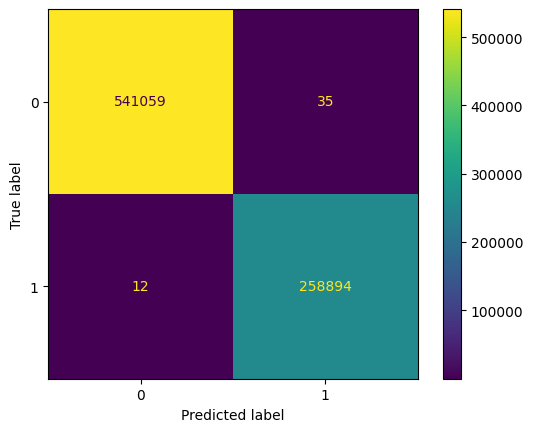

In [50]:
ypred = model5.predict(X_train_cpu)
f1score = f1_score(y_train_cpu, np.round(ypred))
print('f1_score for train:',f1score)
ypred = model5.predict(X_test_cpu)
f1score = f1_score(y_test_cpu, np.round(ypred))
print('f1_score for test:',f1score)
# Dumping model in pickle file
with open('DT.pkl', 'wb') as fp:
 pickle.dump(model5, fp, protocol=pickle.HIGHEST_PROTOCOL)
infile = open('DT.pkl','rb')
model = pickle.load(infile)
infile.close()
scores = cross_validation(model)
print(scores)
print('mean test f1_score: ',scores['test_f1'].mean())
print('mean test macro_f1: ',scores['test_f1_macro'].mean())


cm = confusion_matrix(y_test_cpu, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp.plot(values_format='')  # Remove values from matrix cells
plt.show()